In [ ]:
!pip install pandas==1.1.3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pickle

glove_vectors_path = '/content/drive/MyDrive/6_Donors_choose_NB/glove_vectors'
preprocessed_data = '/content/drive/MyDrive/6_Donors_choose_NB/preprocessed_data.csv'

# **TASK 1:** 

##**`RandomForest Classifier`**

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

pd.set_option('display.width', 10)
pd.set_option('display.max_colwidth', 10)

import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## **1.1 LoadingData**

In [3]:
data = pd.read_csv(preprocessed_data)
data = pd.concat([data.loc[data['project_is_approved'] == 0], data.loc[data['project_is_approved'] == 1].head(33458)], sort=False)

target = data['project_is_approved']
data = data.drop(columns=['project_is_approved'])

data.info() #basic info about dataset : To know how many categorical and numeric data point

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 7 to 39521
Data columns (total 8 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   school_state                                  50000 non-null  object 
 1   teacher_prefix                                50000 non-null  object 
 2   project_grade_category                        50000 non-null  object 
 3   teacher_number_of_previously_posted_projects  50000 non-null  int64  
 4   clean_categories                              50000 non-null  object 
 5   clean_subcategories                           50000 non-null  object 
 6   essay                                         50000 non-null  object 
 7   price                                         50000 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 3.4+ MB


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, ytrain, ytest = train_test_split(data, target, test_size=0.33, stratify=target)

del data
del target

## **1.2 TextFeatures Encoding**



### **1.2.1 Tfidf Vectorization**

In [5]:
############### TFIDF - Vectorizer ######################
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=10, max_features=5000, ngram_range=(1,2))
tfidf.fit(X_train.essay.values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

### **1.2.2 Tfidf-W2V vectorizer**

In [ ]:
################# TFIDF - W2V ###########################
import tqdm

with open(glove_vectors_path, 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

def tfidf_w2v(essay):
    tfidf = TfidfVectorizer(min_df=10, max_features=5000, ngram_range=(1,2))
    tfidf.fit(essay.values)

    dictionary = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
    tfidf_words = set(tfidf.get_feature_names())

    tfidf_w2v_vectors = []

    for sentence in essay:
        vector = np.zeros(300)
        tfidf_weight = 0
        for word in sentence.split():
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word]
                tfidf_vec = dictionary[word] * sentence.count(word) / len(sentence.split())
                vector += vec * tfidf_vec
                tfidf_weight += tfidf_vec
                
        if tfidf_weight != 0:
            vector /= tfidf_vec
        tfidf_w2v_vectors.append(vector)

    return np.array(tfidf_w2v_vectors)

## **1.3 Categorical Feature Encoding & Normalize Numeric Data**

In [6]:
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer

ohe1 = CountVectorizer()
ohe1.fit(X_train['school_state'].values)
school_state_ohe_train = ohe1.transform(X_train['school_state'].values).toarray() # fit has to happen only on train data
school_state_ohe_test = ohe1.transform(X_test['school_state'].values).toarray()

ohe2 = CountVectorizer()
ohe2.fit(X_train['teacher_prefix'].values)
teacher_prefix_ohe_train = ohe2.transform(X_train['teacher_prefix'].values).toarray() # fit has to happen only on train data
teacher_prefix_ohe_test = ohe2.transform(X_test['teacher_prefix'].values).toarray()

ohe3 = CountVectorizer()
ohe3.fit(X_train['project_grade_category'].values)
project_grade_category_ohe_train = ohe3.transform(X_train['project_grade_category'].values).toarray() # fit has to happen only on train data
project_grade_category_ohe_test = ohe3.transform(X_test['project_grade_category'].values).toarray()

ohe4 = CountVectorizer()
ohe4.fit(X_train['clean_categories'].values)
clean_categories_ohe_train = ohe4.transform(X_train['clean_categories'].values).toarray() # fit has to happen only on train data
clean_categories_ohe_test = ohe4.transform(X_test['clean_categories'].values).toarray()

ohe5 = CountVectorizer()
ohe5.fit(X_train['clean_subcategories'].values)
clean_subcategories_ohe_train = ohe5.transform(X_train['clean_subcategories'].values).toarray() # fit has to happen only on train data
clean_subcategories_ohe_test = ohe5.transform(X_test['clean_subcategories'].values).toarray()

norm = Normalizer()
norm.fit(X_train['price'].values.reshape(-1,1))
X_train_price_norm = norm.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = norm.transform(X_test['price'].values.reshape(-1,1))

norm.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_train_no_prev_proj = norm.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_no_prev_proj = norm.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [7]:
import gc

X_train_essay = X_train['essay']
X_test_essay = X_test['essay']

X_train = np.column_stack((X_train_no_prev_proj, X_train_price_norm, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train, clean_subcategories_ohe_train))
X_test = np.column_stack((X_test_no_prev_proj, X_test_price_norm, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test, clean_subcategories_ohe_test))

gc.collect()

print("Final Data matrix")
print(X_train.shape, ytrain.shape)
print(X_test.shape, ytest.shape)

print("="*100)

Final Data matrix
(33500, 101) (33500,)
(16500, 101) (16500,)


## **1.4 Sentiment Analyser**

In [8]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sentiment_anayser(essay):
    sid = SentimentIntensityAnalyzer()
    negative = []
    positive = []
    neutral = []
    for sentence in essay:
        ss = sid.polarity_scores(sentence)
        sentmnt = list(ss.values())
        neg = sentmnt[0]
        neu = sentmnt[1]
        pos = sentmnt[2]
        negative.append(neg)
        neutral.append(neu)
        positive.append(pos)
    return np.column_stack((np.array(negative), np.array(neutral), np.array(positive)))

## **1.5 Hyper_Parameter Tuning** (SET1 & SET2)

In [12]:
from sklearn.model_selection import GridSearchCV

sets = ['tfidf_w2v_vectors', 'tfidf']
scorer = dict()

X_train = np.column_stack((X_train, sentiment_anayser(X_train_essay)))

for index, df_set in enumerate(sets):

    if df_set == 'tfidf':
        temp = tfidf.transform(X_train_essay).toarray()
        X = np.column_stack((X_train, temp))
        
    elif df_set == 'tfidf_w2v_vectors': 
        temp = tfidf_w2v(X_train_essay)
        X = np.column_stack((X_train, temp))
    
    print("Final Data matrix")
    print(X.shape, ytrain.shape)

    parameters={'max_depth' : [1, 5, 10, 50], 'min_samples_split' : [5, 10, 100, 500]}

    gsc=GridSearchCV(estimator=RandomForestClassifier(random_state=2),
                     param_grid=parameters, scoring='roc_auc', verbose=1, n_jobs=2, return_train_score=True)
    
    grid_result = gsc.fit(X, ytrain)
    scorer[df_set] = grid_result.cv_results_

    print("#"*50,"\n\n")
    print("\n", df_set, " : ", "\n")

    best_params=grid_result.best_params_
    print(best_params)

    print(grid_result.best_score_,"\n")
    print("#"*50,"\n\n")

    del X
    del temp
    gc.collect()

Final Data matrix
(33500, 404) (33500,)
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.4min
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed: 23.9min finished


################################################## 



 tfidf_w2v_vectors  :  

{'max_depth': 50, 'min_samples_split': 100}
0.6811385798074181 

################################################## 


Final Data matrix
(33500, 5104) (33500,)
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed: 27.8min finished


################################################## 



 tfidf  :  

{'max_depth': 50, 'min_samples_split': 500}
0.7034708676646971 

################################################## 




In [13]:
scorer['tfidf_w2v_vectors']

{'mean_fit_time': array([ 6.53642168,  6.50008607,  6.446486  ,  6.50317445, 27.50075483,
        27.53363948, 28.96187649, 27.01472712, 48.22469082, 48.23755665,
        46.74311256, 39.58104491, 70.05630026, 69.74470596, 57.81148353,
        40.45910616]),
 'mean_score_time': array([0.08072991, 0.07817049, 0.07889657, 0.07854581, 0.10959311,
        0.11522694, 0.1120954 , 0.1117126 , 0.15585575, 0.15923347,
        0.15560122, 0.13585005, 0.24112983, 0.23229437, 0.18090439,
        0.13065448]),
 'mean_test_score': array([0.64377895, 0.64377895, 0.64377895, 0.64377895, 0.66769097,
        0.66770627, 0.66716528, 0.66538161, 0.68046042, 0.6801951 ,
        0.68093711, 0.67588345, 0.67066628, 0.67177212, 0.68113858,
        0.67665995]),
 'mean_train_score': array([0.6512802 , 0.6512802 , 0.6512802 , 0.6512802 , 0.70963937,
        0.70960247, 0.70685385, 0.69939117, 0.9209857 , 0.91508418,
        0.84125539, 0.75034393, 0.99999963, 0.99999773, 0.93422663,
        0.7603309 ]),
 'par

In [14]:
scorer['tfidf']

{'mean_fit_time': array([  5.4144527 ,   4.95163836,   5.29698291,   5.09564219,
         17.84639125,  17.83705859,  17.82873521,  17.61748381,
         33.17415762,  33.25331221,  33.3099905 ,  32.27718129,
        107.95508366, 105.7434628 , 102.11645894,  88.4779398 ]),
 'mean_score_time': array([0.19195576, 0.197367  , 0.20865006, 0.20786195, 0.28999205,
        0.29331164, 0.28994403, 0.28318238, 0.38448644, 0.38372707,
        0.38623033, 0.37853475, 0.94770823, 0.94924035, 0.89747052,
        0.71370134]),
 'mean_test_score': array([0.64550969, 0.64550969, 0.64550969, 0.64550969, 0.67746338,
        0.6771413 , 0.67621447, 0.6768039 , 0.688689  , 0.68759127,
        0.68912801, 0.68800068, 0.69509522, 0.69683486, 0.70105653,
        0.70347087]),
 'mean_train_score': array([0.65614264, 0.65614264, 0.65614264, 0.65614264, 0.72598749,
        0.72485513, 0.71822928, 0.70981083, 0.82096228, 0.81520093,
        0.78376446, 0.7529182 , 0.99996942, 0.99989844, 0.9897343 ,
        0.9

## **1.6 Cross-Validation Results**

In [15]:
mean_test_score = [0.65820944, 0.65820944, 0.65820944, 0.65820944, 0.68122492, 0.68113072, 0.68077205, 0.68077527, 
                   0.69357459, 0.69372878, 0.69341197, 0.69277492, 0.70191902, 0.70235819, 0.70424156, 0.70644806]

mean_train_score = [0.66895523, 0.66895523, 0.66895523, 0.66895523, 0.73153556, 0.73019983, 0.72432353, 0.71632896, 
                    0.82714781, 0.82142404, 0.7903215 , 0.75914939, 0.9999747 , 0.99989934, 0.99099531, 0.91503008]

params = [{'max_depth': 1, 'min_samples_split': 5},
  {'max_depth': 1, 'min_samples_split': 10},
  {'max_depth': 1, 'min_samples_split': 100},
  {'max_depth': 1, 'min_samples_split': 500},
  {'max_depth': 5, 'min_samples_split': 5},
  {'max_depth': 5, 'min_samples_split': 10},
  {'max_depth': 5, 'min_samples_split': 100},
  {'max_depth': 5, 'min_samples_split': 500},
  {'max_depth': 10, 'min_samples_split': 5},
  {'max_depth': 10, 'min_samples_split': 10},
  {'max_depth': 10, 'min_samples_split': 100},
  {'max_depth': 10, 'min_samples_split': 500},
  {'max_depth': 50, 'min_samples_split': 5},
  {'max_depth': 50, 'min_samples_split': 10},
  {'max_depth': 50, 'min_samples_split': 100},
  {'max_depth': 50, 'min_samples_split': 500}]

In [16]:
max_depths = []
min_samples_split = []

for parameter in params:
    max_depths.append(parameter['max_depth'])
    min_samples_split.append(parameter['min_samples_split'])

df = pd.DataFrame()
df['max_depth'] = pd.Series(max_depths)
df['min_samples_split'] = pd.Series(min_samples_split)
df['mean_test_score'] = mean_test_score
df['mean_train_score'] = mean_train_score

train_heatmap = df.pivot(index='min_samples_split', columns='max_depth', values='mean_train_score')
test_heatmap = df.pivot(index='min_samples_split', columns='max_depth', values='mean_test_score')

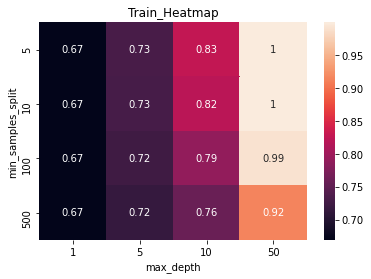

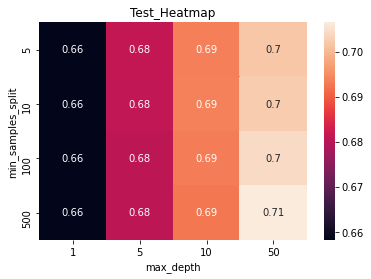

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(train_heatmap, annot=True)
plt.title("Train_Heatmap")
plt.show()

sns.heatmap(test_heatmap, annot=True)
plt.title("Test_Heatmap")
plt.show()

## **1.7 Model Train & Predict**

In [9]:
X_train = np.column_stack((X_train, sentiment_anayser(X_train_essay)))
temp = tfidf.transform(X_train_essay).toarray()
X_train = np.column_stack((X_train, temp))

X_test = np.column_stack((X_test, sentiment_anayser(X_test_essay)))
temp = tfidf.transform(X_test_essay).toarray()
X_test = np.column_stack((X_test, temp))

X_train.shape, X_test.shape

((33500, 5104), (16500, 5104))

In [10]:
model = RandomForestClassifier(max_depth = 50, min_samples_split= 500, random_state=2)
model = model.fit(X_train, ytrain)
Y_pred = model.predict(X_test)

## **1.8 ConfusionMatrix**

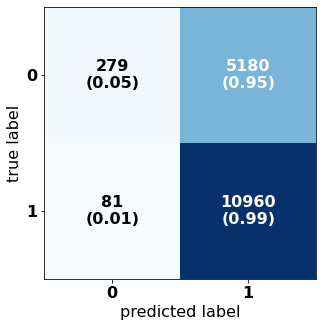

In [11]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

font = {
'family' : 'DejaVu Sans',
'weight' : 'bold',
'size' : '16'
}

plt.rc('font', **font)
mat = confusion_matrix(ytest, Y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(5,5), show_normed=True);

## **1.9 AUC-Plot**

In [12]:
from sklearn.metrics import auc

print("train_roc_auc_score : " , roc_auc_score(ytrain, model.predict(X_train)), '\n')
print("test_roc_auc_score : ", roc_auc_score(ytest, Y_pred), '\n')

probs = model.predict_proba(X_train)
probs = probs[:, 1]

train_fpr, train_tpr, train_thresholds = roc_curve(ytrain, probs)

probs = model.predict_proba(X_test)
probs = probs[:, 1]

test_fpr, test_tpr, test_thresholds = roc_curve(ytest, probs)

print("train_auc_score : " , auc(train_fpr, train_tpr), '\n')
print("test_auc_score : ", auc(test_fpr, test_tpr), '\n')

train_roc_auc_score :  0.5670076296286061 

test_roc_auc_score :  0.5218859847919176 

train_auc_score :  0.9133752024687409 

test_auc_score :  0.713452576359503 



train_auc_score :  0.9133752024687409 


test_auc_score :  0.713452576359503 




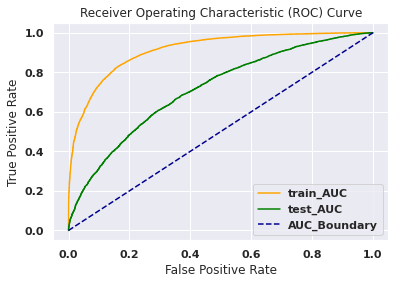

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
sns.set(style='darkgrid')

print("train_auc_score : " , auc(train_fpr, train_tpr), "\n\n")
print("test_auc_score : ", auc(test_fpr, test_tpr), "\n\n")

plt.plot(train_fpr, train_tpr, color='orange', label='_train_ROC')
plt.plot(test_fpr, test_tpr, color='green', label='_test_ROC')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(['train_AUC', 'test_AUC', 'AUC_Boundary'])
plt.show();

## **1.10 False-Positive Prediction WordCloud**

In [14]:
from wordcloud import WordCloud, STOPWORDS

Y_pred = Y_pred.tolist()

ytest = ytest.tolist()

false_positive = []

for index in range(len(Y_pred)):
    if ytest[index] == 0 and Y_pred[index] == 1:
        false_positive.append(index)

################################################## 
 WORDS IN ESSAYS - FOR FALSE-POSITIVE PREDICTIONS 
 ##################################################


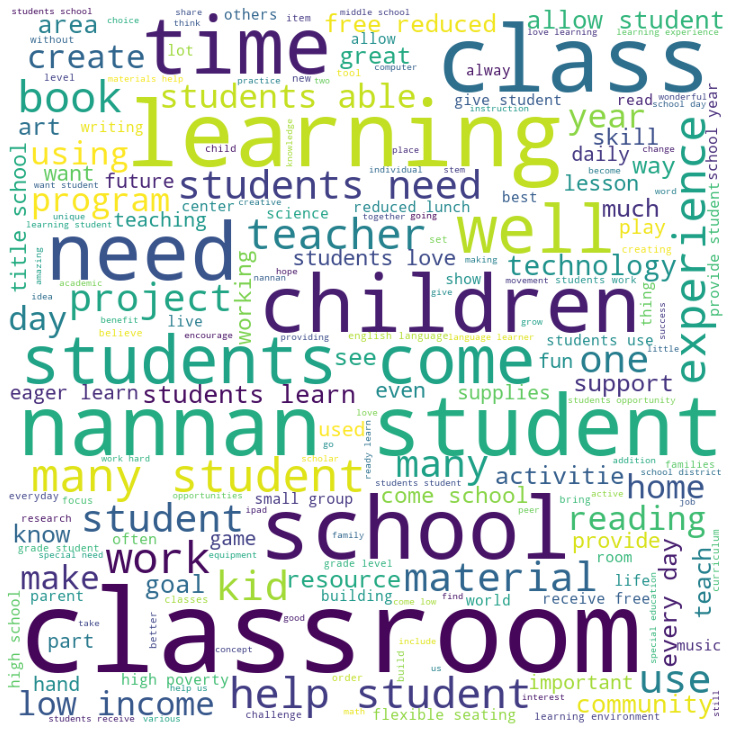

In [15]:
data = pd.read_csv(preprocessed_data)
data = pd.concat([data.loc[data['project_is_approved'] == 0], data.loc[data['project_is_approved'] == 1].head(33458)], sort=False)
data = data.drop(columns=['project_is_approved'])

fp_essay = data.iloc[false_positive]['essay']
fp_price = data.iloc[false_positive]['price']
fp_teacher_number_of_previously_posted_projects = data.iloc[false_positive]['teacher_number_of_previously_posted_projects']

stopwords = set(STOPWORDS)
word_cloud = []
print('#'*50, '\n', 'WORDS IN ESSAYS - FOR FALSE-POSITIVE PREDICTIONS', '\n', '#'*50)
comment_words = ""

for sentence in fp_essay:
    for words in sentence.split():
        word_cloud.append(words.lower())
        
comment_words += " ".join(word_cloud)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

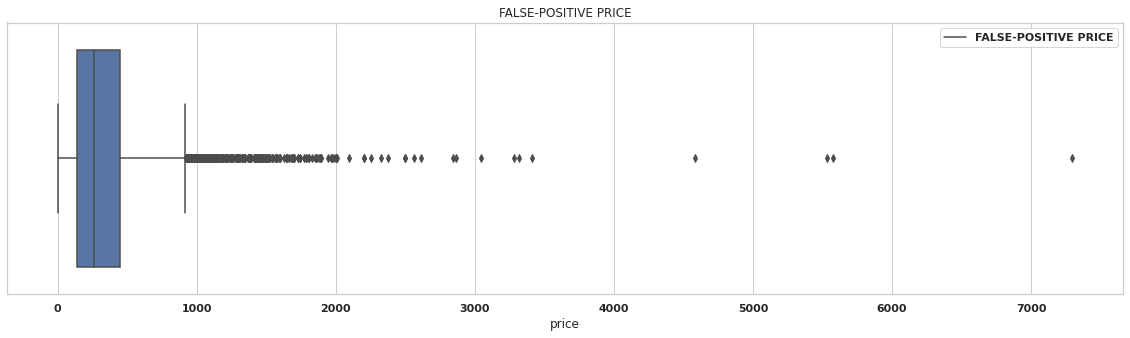

In [16]:
import seaborn as sns

plt.figure(figsize=(20,5))

sns.set_theme(style="whitegrid")
sns.boxplot(fp_price)

plt.title("FALSE-POSITIVE PRICE")
plt.legend(["FALSE-POSITIVE PRICE"])
plt.show()

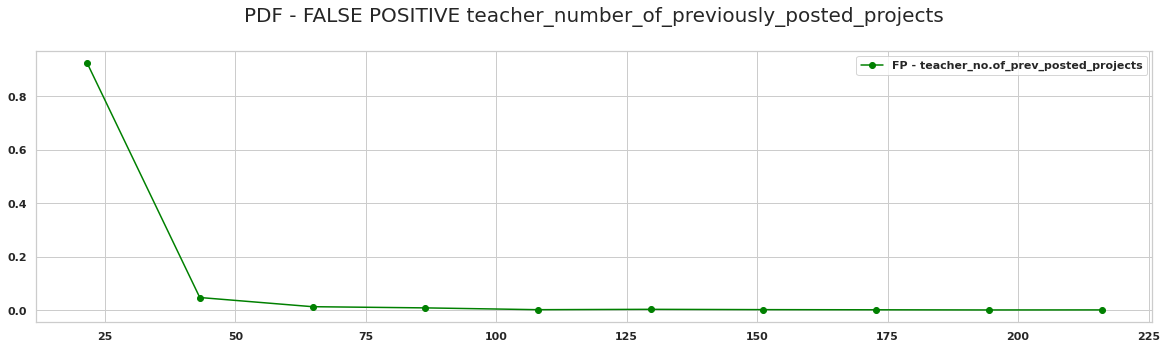

In [17]:
sns.set_style("whitegrid");
plt.figure(figsize=(20,5))

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 10

count, bin_edges = np.histogram(fp_teacher_number_of_previously_posted_projects, bins=10, density=True)

nodes_pdf = count / sum(count)
nodes_cdf = np.cumsum(nodes_pdf)

plt.plot(bin_edges[1:],nodes_pdf, color='green', marker='o', linestyle='solid')

plt.title("PDF - FALSE POSITIVE teacher_number_of_previously_posted_projects\n")
plt.legend(['FP - teacher_no.of_prev_posted_projects'])
plt.show();

# **TASK 2:** 

##**`DecisionTree Classifier`**

In [18]:
print(X_train.shape, ytrain.shape, X_test.shape, np.array(ytest).shape) #SET 1 - TFIDF

(33500, 5104) (33500,) (16500, 5104) (16500,)


## **2.1 Non-Zero Feature Importance Feature Selection**

In [19]:
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=2)
model = model.fit(X_train, ytrain)

In [20]:
non_zero_Feature_importance_index = [index for index, value in enumerate(model.feature_importances_.tolist()) if value != float(0.0)]

In [21]:
print(len(non_zero_Feature_importance_index))

X = np.take(X_train, non_zero_Feature_importance_index, axis=1)
X_ = np.take(X_test, non_zero_Feature_importance_index, axis=1)

print(X.shape, X_.shape)

1992
(33500, 1992) (16500, 1992)


## **2.2 Hyper_Parameter Tuning**

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

parameters={'max_depth' : [1, 5, 10, 50, 'None'], 'min_samples_split' : [2, 5, 10, 100, 500]}

gsc=GridSearchCV(estimator=DecisionTreeClassifier(random_state=2),
                    param_grid=parameters, scoring='roc_auc', verbose=1, n_jobs=-1, return_train_score=True)

grid_result = gsc.fit(X, ytrain)

print("#"*50,"\n\n")
best_params=grid_result.best_params_
print(best_params,'\n')
print(grid_result.best_score_,"\n")
print("#"*50,"\n\n")

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 12.5min finished


################################################## 


{'max_depth': 10, 'min_samples_split': 500} 

0.6416584598675767 

################################################## 




In [23]:
grid_result.cv_results_

{'mean_fit_time': array([ 2.16149755,  2.03612494,  2.04942455,  2.06100979,  2.04422913,
         7.94701281,  7.89494824,  7.89863539,  7.8644557 ,  7.86954598,
        13.73311086, 13.7625011 , 13.75112782, 13.63686953, 13.24367671,
        35.84308181, 35.85975919, 35.53652792, 35.00844431, 28.83373485,
         0.36750345,  0.35105982,  0.34450002,  0.353444  ,  0.33779845]),
 'mean_score_time': array([0.05628324, 0.05030651, 0.05176606, 0.05159874, 0.05081816,
        0.0578064 , 0.06128101, 0.0604774 , 0.05833521, 0.05767779,
        0.05676041, 0.05874224, 0.05812917, 0.05730886, 0.0555511 ,
        0.0597394 , 0.05844855, 0.05873723, 0.06554189, 0.05359812,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'mean_test_score': array([0.57006531, 0.57006531, 0.57006531, 0.57006531, 0.57006531,
        0.62769167, 0.62769167, 0.62755632, 0.62757599, 0.6275973 ,
        0.63199893, 0.63202057, 0.63048601, 0.63643141, 0.64165846,
        0.547114  , 0.54951562, 

## **2.3 Cross-Validation Result**

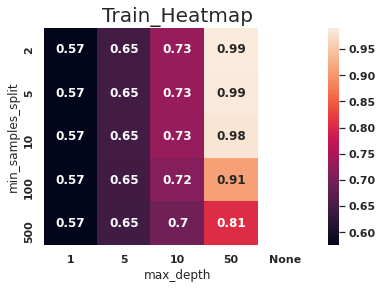

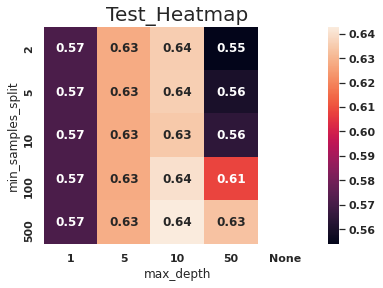

In [24]:
params = [{'max_depth': 1, 'min_samples_split': 2},
  {'max_depth': 1, 'min_samples_split': 5},
  {'max_depth': 1, 'min_samples_split': 10},
  {'max_depth': 1, 'min_samples_split': 100},
  {'max_depth': 1, 'min_samples_split': 500},
  {'max_depth': 5, 'min_samples_split': 2},
  {'max_depth': 5, 'min_samples_split': 5},
  {'max_depth': 5, 'min_samples_split': 10},
  {'max_depth': 5, 'min_samples_split': 100},
  {'max_depth': 5, 'min_samples_split': 500},
  {'max_depth': 10, 'min_samples_split': 2},
  {'max_depth': 10, 'min_samples_split': 5},
  {'max_depth': 10, 'min_samples_split': 10},
  {'max_depth': 10, 'min_samples_split': 100},
  {'max_depth': 10, 'min_samples_split': 500},
  {'max_depth': 50, 'min_samples_split': 2},
  {'max_depth': 50, 'min_samples_split': 5},
  {'max_depth': 50, 'min_samples_split': 10},
  {'max_depth': 50, 'min_samples_split': 100},
  {'max_depth': 50, 'min_samples_split': 500},
  {'max_depth': 'None', 'min_samples_split': 2},
  {'max_depth': 'None', 'min_samples_split': 5},
  {'max_depth': 'None', 'min_samples_split': 10},
  {'max_depth': 'None', 'min_samples_split': 100},
  {'max_depth': 'None', 'min_samples_split': 500}]

mean_test_score = np.array([0.57130322, 0.57130322, 0.57130322, 0.57130322, 0.57130322,
                            0.62814354, 0.62814354, 0.62814354, 0.6280679 , 0.62862218,
                            0.63576448, 0.63606226, 0.63465875, 0.64017402, 0.64283563,
                            0.55380708, 0.56002823, 0.56476647, 0.60818671, 0.63312122,
                            np.nan,        np.nan,        np.nan,        np.nan,        np.nan])
mean_train_score = np.array([0.57493185, 0.57493185, 0.57493185, 0.57493185, 0.57493185,
                             0.64836227, 0.64836227, 0.64834003, 0.64771022, 0.64598223,
                             0.73365531, 0.73309553, 0.73175414, 0.71574084, 0.69606365,
                             0.99068627, 0.98902076, 0.98316671, 0.91041784, 0.80675576,
                             np.nan,        np.nan,        np.nan,        np.nan,        np.nan])

mean_train_score = pd.Series(mean_train_score)
mean_test_score = pd.Series(mean_test_score)

min_samples_split = []
max_depth = []
for parameter in params:
    min_samples_split.append(parameter['min_samples_split'])
    max_depth.append(parameter['max_depth'])

df = pd.DataFrame()
df['min_samples_split'] = pd.Series(min_samples_split)
df['mean_test_score'] = mean_test_score
df['mean_train_score'] = mean_train_score
df['max_depth'] = pd.Series(max_depth)

train_heatmap = df.pivot(index='min_samples_split', columns='max_depth', values='mean_train_score')
test_heatmap = df.pivot(index='min_samples_split', columns='max_depth', values='mean_test_score')

sns.heatmap(train_heatmap, annot=True)
plt.title("Train_Heatmap")
plt.show()

sns.heatmap(test_heatmap, annot=True)
plt.title("Test_Heatmap")
plt.show()

## **2.4 Model Train**

In [25]:
model = DecisionTreeClassifier(random_state=2, max_depth=10, min_samples_split=500)
model.fit(X, ytrain)
Y_pred = model.predict(X_)

## **2.5 ConfusionMatrix**

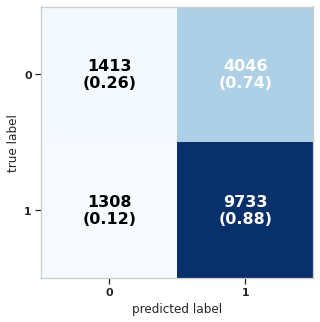

In [26]:
font = {
'family' : 'DejaVu Sans',
'weight' : 'bold',
'size' : '16'
}

plt.rc('font', **font)
mat = confusion_matrix(ytest, Y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(5,5), show_normed=True);

## **2.6 AUC-Plot**

In [27]:
from sklearn.metrics import auc

print("train_roc_auc_score : " , roc_auc_score(ytrain, model.predict(X)),'\n')
print("test_roc_auc_score : ", roc_auc_score(ytest, Y_pred), '\n')

probs = model.predict_proba(X)
probs = probs[:, 1]
train_fpr, train_tpr, train_thresholds = roc_curve(ytrain, probs)

probs = model.predict_proba(X_)
probs = probs[:, 1]
test_fpr, test_tpr, test_thresholds = roc_curve(ytest, probs)

print("train_auc_score : " , auc(train_fpr, train_tpr), '\n')
print("test_auc_score : ", auc(test_fpr, test_tpr), '\n')


train_roc_auc_score :  0.6014207619005844 

test_roc_auc_score :  0.5701855425079753 

train_auc_score :  0.6959339045526182 

test_auc_score :  0.6463583111982867 



train_auc_score :  0.6959339045526182 


test_auc_score :  0.6463583111982867 




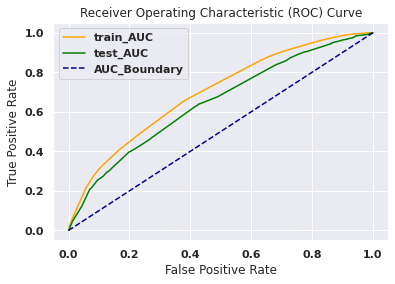

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
sns.set(style='darkgrid')
print("train_auc_score : " , auc(train_fpr, train_tpr), "\n\n")
print("test_auc_score : ", auc(test_fpr, test_tpr), "\n\n")

plt.plot(train_fpr, train_tpr, color='orange', label='_train_ROC')
plt.plot(test_fpr, test_tpr, color='green', label='_test_ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(['train_AUC', 'test_AUC', 'AUC_Boundary'])
plt.show();

# **`RESULT`**

---


In [29]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper_Parameter", "Train_AUC", "Test_AUC"]
x.add_row(["TFIDF-W2V", 'RandomForest', 'max_depth : 50, min_samples_split : 100', 0.93, 0.68])
x.add_row(["TFIDF", 'RandomForest', 'max_depth : 50, min_samples_split : 500', 0.92, 0.71])
x.add_row(["TFIDF", 'DecisionTree', 'max_depth : 10, min_samples_split : 500', 0.69, 0.64])

print(x)

+------------+--------------+-----------------------------------------+-----------+----------+
| Vectorizer |    Model     |             Hyper_Parameter             | Train_AUC | Test_AUC |
+------------+--------------+-----------------------------------------+-----------+----------+
| TFIDF-W2V  | RandomForest | max_depth : 50, min_samples_split : 100 |    0.93   |   0.68   |
|   TFIDF    | RandomForest | max_depth : 50, min_samples_split : 500 |    0.92   |   0.71   |
|   TFIDF    | DecisionTree | max_depth : 10, min_samples_split : 500 |    0.69   |   0.64   |
+------------+--------------+-----------------------------------------+-----------+----------+
